# UTS Machine Learning
## Aryo Adi Putro - 2341720084

In [2]:
try:
  import gdown
except ImportError:
  !pip install gdown
  import gdown

gdown.download(id='1RrrpOhMf9oAZEkLmhXr_6PV2UrHZqPD6', output='train.csv', quiet=False)

IMG_PATHS = ["train.csv"]

Downloading...
From: https://drive.google.com/uc?id=1RrrpOhMf9oAZEkLmhXr_6PV2UrHZqPD6
To: /content/train.csv
100%|██████████| 461k/461k [00:00<00:00, 102MB/s]


In [3]:
!pip install annoy

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

df = pd.read_csv("train.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551518 sha256=28301f4e68123757722d30ee8a4a9460161698dff8104b995adf046598c43f0f
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


### Preprocessing data

In [4]:
print("=== Informasi Dataset ===")
print(df.info())
print("\nJumlah baris & kolom:", df.shape)
print("\nContoh data:")
display(df.head())

print("\n=== Missing Values per Kolom ===")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
display(missing)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns

print("\nJumlah fitur numerik:", len(num_cols))
print("Jumlah fitur kategorikal:", len(cat_cols))

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.mean()))
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns:
    df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    print("\nFitur baru 'TotalArea' berhasil dibuat!")
else:
    print("\nKolom GrLivArea atau TotalBsmtSF tidak ditemukan dalam dataset.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])

df_scaled = pd.DataFrame(X_scaled, columns=num_cols)
df_scaled['TotalArea'] = df['TotalArea']

print("\n=== Ringkasan Setelah Preprocessing ===")
print("Jumlah total fitur:", df_scaled.shape[1])
print("Jumlah data:", df_scaled.shape[0])
print("\nStatistik deskriptif setelah standarisasi:")
display(df_scaled.describe().T)

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



=== Missing Values per Kolom ===


,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81



Jumlah fitur numerik: 38
Jumlah fitur kategorikal: 43

Fitur baru 'TotalArea' berhasil dibuat!

=== Ringkasan Setelah Preprocessing ===
Jumlah total fitur: 39
Jumlah data: 1460

Statistik deskriptif setelah standarisasi:


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,0.000000e+00,1.000343,-1.730865,-0.865432,0.000000e+00,0.865432,1.730865
MSSubClass,1460.0,-8.455945e-17,1.000343,-0.872563,-0.872563,-1.631095e-01,0.309859,3.147673
LotFrontage,1460.0,4.075887e-16,1.000343,-2.227875,-0.456474,6.454645e-16,0.406516,11.034918
LotArea,1460.0,-5.840077e-17,1.000343,-0.923729,-0.296991,-1.040633e-01,0.108708,20.518273
OverallQual,1460.0,1.387018e-16,1.000343,-3.688413,-0.795151,-7.183611e-02,0.651479,2.821425
OverallCond,1460.0,3.540547e-16,1.000343,-4.112970,-0.517200,-5.171998e-01,0.381743,3.078570
YearBuilt,1460.0,1.046347e-15,1.000343,-3.287824,-0.571923,5.737148e-02,0.951632,1.282839
YearRemodAdd,1460.0,4.496860e-15,1.000343,-1.689368,-0.865659,4.425864e-01,0.927122,1.217843
MasVnrArea,1460.0,-3.406712e-17,1.000343,-0.574410,-0.574410,-5.744105e-01,0.335525,8.289499
BsmtFinSF1,1460.0,-2.433366e-17,1.000343,-0.973018,-0.973018,-1.319022e-01,0.589133,11.405753


### Clustering


=== Evaluasi Clustering ===
KMeans Silhouette Score: 0.1382
KMeans Davies–Bouldin Index: 2.4938
DBSCAN Silhouette Score: -0.1939
DBSCAN Davies–Bouldin Index: 1.9043


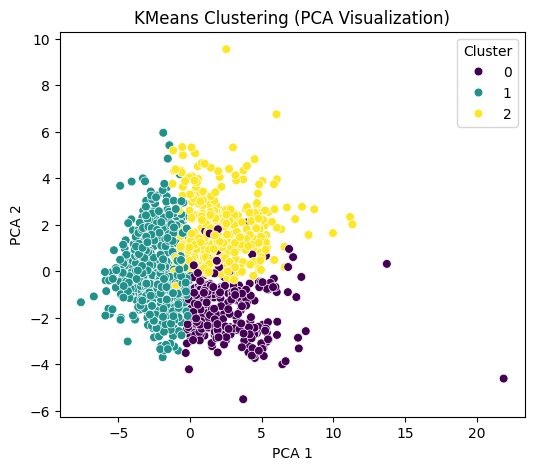

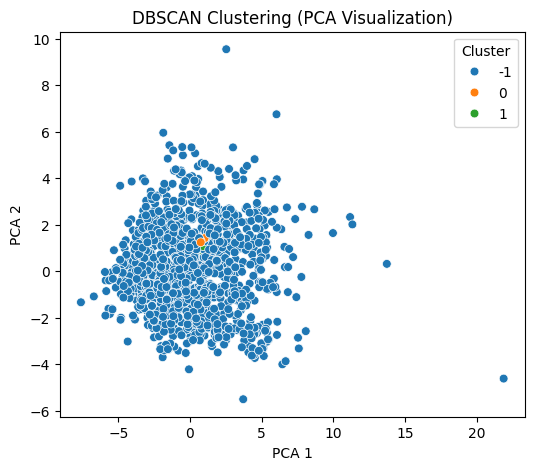

In [21]:
X = df_scaled.dropna().values

kmeans = KMeans(n_clusters=3, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)

print("\n=== Evaluasi Clustering ===")
if len(set(labels_kmeans)) > 1:
    sil_kmeans = silhouette_score(X, labels_kmeans)
    dbi_kmeans = davies_bouldin_score(X, labels_kmeans)
    print(f"KMeans Silhouette Score: {sil_kmeans:.4f}")
    print(f"KMeans Davies–Bouldin Index: {dbi_kmeans:.4f}")
else:
    print("KMeans menghasilkan hanya satu cluster.")

if len(set(labels_dbscan)) > 1:
    sil_dbscan = silhouette_score(X, labels_dbscan)
    dbi_dbscan = davies_bouldin_score(X, labels_dbscan)
    print(f"DBSCAN Silhouette Score: {sil_dbscan:.4f}")
    print(f"DBSCAN Davies–Bouldin Index: {dbi_dbscan:.4f}")
else:
    print("DBSCAN menghasilkan hanya satu cluster (atau semua -1 = noise).")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette='viridis', s=40)
plt.title("KMeans Clustering (PCA Visualization)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dbscan, palette='tab10', s=40)
plt.title("DBSCAN Clustering (PCA Visualization)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

### Penerepan ANNOY

In [6]:
import random

X = df_scaled.values
dim = X.shape[1]

ann = AnnoyIndex(dim, 'euclidean')

for i in range(len(X)):
    ann.add_item(i, X[i])

n_trees = 10
ann.build(n_trees)
print(f"Annoy index berhasil dibuat dengan {n_trees} trees dan {len(X)} data.")

num_queries = 5
query_indices = random.sample(range(len(X)), num_queries)

n_neighbors = 5
print("\n=== Hasil Pencarian Nearest Neighbors ===\n")

for q_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(q_idx, n_neighbors, include_distances=True)

    print(f"Query Point Index: {q_idx}")
    print("Cluster (KMeans):", labels_kmeans[q_idx])
    print("Tetangga Terdekat & Jaraknya:")

    for n, d in zip(neighbors, distances):
        print(f"  - Neighbor Index: {n:<6} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")
    print("-" * 60)

Annoy index berhasil dibuat dengan 10 trees dan 1460 data.

=== Hasil Pencarian Nearest Neighbors ===

Query Point Index: 962
Cluster (KMeans): 1
Tetangga Terdekat & Jaraknya:
  - Neighbor Index: 962    | Distance: 0.0000 | Cluster (KMeans): 1
  - Neighbor Index: 590    | Distance: 4.9006 | Cluster (KMeans): 1
  - Neighbor Index: 1106   | Distance: 7.5617 | Cluster (KMeans): 1
  - Neighbor Index: 717    | Distance: 7.8488 | Cluster (KMeans): 1
  - Neighbor Index: 989    | Distance: 7.9485 | Cluster (KMeans): 1
------------------------------------------------------------
Query Point Index: 369
Cluster (KMeans): 1
Tetangga Terdekat & Jaraknya:
  - Neighbor Index: 369    | Distance: 0.0000 | Cluster (KMeans): 1
  - Neighbor Index: 590    | Distance: 7.9856 | Cluster (KMeans): 1
  - Neighbor Index: 1106   | Distance: 8.0864 | Cluster (KMeans): 1
  - Neighbor Index: 962    | Distance: 8.2716 | Cluster (KMeans): 1
  - Neighbor Index: 717    | Distance: 8.8849 | Cluster (KMeans): 1
----------

### Langkah Tambahan

#### Preprocessing data

In [7]:
train_path = '/content/train.csv'
df = pd.read_csv(train_path)

num_df = df.select_dtypes(include=['int64', 'float64']).copy()
print(f"Jumlah fitur numerik sebelum pemrosesan: {num_df.shape[1]}")

num_df = num_df.fillna(num_df.mean())

if 'GrLivArea' in num_df.columns and 'TotalBsmtSF' in num_df.columns:
    num_df['TotalArea'] = num_df['GrLivArea'] + num_df['TotalBsmtSF']
    print("Fitur baru 'TotalArea' berhasil dibuat.")
else:
    print("Kolom GrLivArea atau TotalBsmtSF tidak ditemukan!")

for col in ['Id', 'SalePrice']:
    if col in num_df.columns:
        num_df.drop(columns=[col], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)
df_scaled = pd.DataFrame(X_scaled, columns=num_df.columns)

df_scaled.to_csv('/content/house_prices_numeric_preprocessed.csv', index=False)
print("\nData numerik bersih dan sudah distandarisasi.")
print("Jumlah fitur setelah seleksi:", df_scaled.shape[1])
print("Jumlah sampel:", df_scaled.shape[0])
print("\nContoh data setelah preprocessing:")
display(df_scaled.head())

Jumlah fitur numerik sebelum pemrosesan: 38
Fitur baru 'TotalArea' berhasil dibuat.

Data numerik bersih dan sudah distandarisasi.
Jumlah fitur setelah seleksi: 37
Jumlah sampel: 1460

Contoh data setelah preprocessing:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalArea
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,-0.008372
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,-0.059386
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.161672
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.121330
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.935372


#### Clustering

Dataset siap digunakan untuk clustering: 1460 sampel, 37 fitur

=== Evaluasi Clustering ===
KMeans → Silhouette Score: 0.1366 | Davies–Bouldin Index: 2.5064
DBSCAN → Silhouette Score: -0.1939 | Davies–Bouldin Index: 1.9043


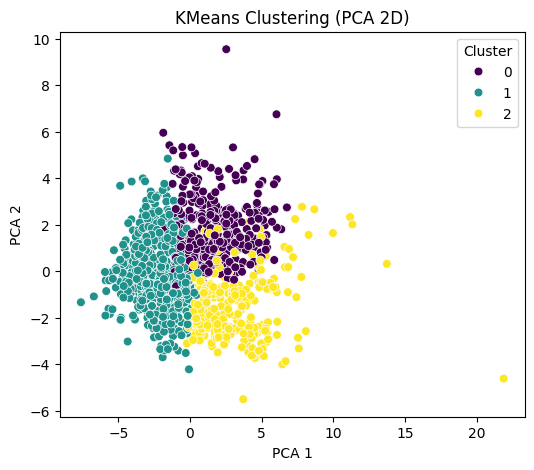

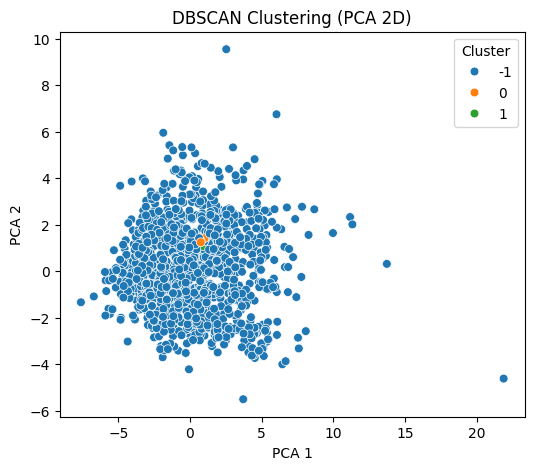

In [22]:
df_scaled = pd.read_csv('/content/house_prices_numeric_preprocessed.csv')
X = df_scaled.values

print(f"Dataset siap digunakan untuk clustering: {X.shape[0]} sampel, {X.shape[1]} fitur")

kmeans = KMeans(n_clusters=3, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)

print("\n=== Evaluasi Clustering ===")

def evaluate(labels, X, name):
    """Hitung metrik evaluasi untuk clustering."""
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        print(f"{name} → Silhouette Score: {sil:.4f} | Davies–Bouldin Index: {dbi:.4f}")
    else:
        print(f"{name} → Tidak dapat dihitung (hanya satu cluster).")

evaluate(labels_kmeans, X, "KMeans")
evaluate(labels_dbscan, X, "DBSCAN")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette='viridis', s=40)
plt.title("KMeans Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dbscan, palette='tab10', s=40)
plt.title("DBSCAN Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

#### Penerapan ANNOY

In [9]:
dim = X.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Tambahkan semua data ke index
for i in range(len(X)):
    ann.add_item(i, X[i])

n_trees = 10
ann.build(n_trees)

# Pilih beberapa query point acak
num_queries = 5
query_indices = random.sample(range(len(X)), num_queries)
n_neighbors = 5

print("\n=== Hasil Pencarian Nearest Neighbors ===\n")
for q_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(q_idx, n_neighbors, include_distances=True)
    print(f" Query Index: {q_idx}")
    print(f"Cluster (KMeans): {labels_kmeans[q_idx]}")
    print("Tetangga terdekat:")
    for n, d in zip(neighbors, distances):
        print(f"  - Neighbor: {n:<5} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")
    print("-" * 60)


=== Hasil Pencarian Nearest Neighbors ===

 Query Index: 1050
Cluster (KMeans): 1
Tetangga terdekat:
  - Neighbor: 1050  | Distance: 0.0000 | Cluster (KMeans): 1
  - Neighbor: 415   | Distance: 0.8493 | Cluster (KMeans): 1
  - Neighbor: 401   | Distance: 1.8465 | Cluster (KMeans): 1
  - Neighbor: 742   | Distance: 2.0888 | Cluster (KMeans): 1
  - Neighbor: 388   | Distance: 2.1078 | Cluster (KMeans): 1
------------------------------------------------------------
 Query Index: 1214
Cluster (KMeans): 2
Tetangga terdekat:
  - Neighbor: 1214  | Distance: 0.0000 | Cluster (KMeans): 2
  - Neighbor: 97    | Distance: 2.4586 | Cluster (KMeans): 2
  - Neighbor: 609   | Distance: 2.7466 | Cluster (KMeans): 2
  - Neighbor: 10    | Distance: 3.0438 | Cluster (KMeans): 2
  - Neighbor: 951   | Distance: 3.1183 | Cluster (KMeans): 2
------------------------------------------------------------
 Query Index: 440
Cluster (KMeans): 1
Tetangga terdekat:
  - Neighbor: 440   | Distance: 0.0000 | Cluster (K